In [1]:
%load_ext autoreload
%autoreload 2

# Модель LGBM

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split

import lightgbm as lgb

import shap

import os
import src

from dotenv import load_dotenv

import joblib

In [4]:
pd.options.display.float_format = '{:,.2f}'.format

## Подготовка данных

In [5]:
load_dotenv(override=True)

WORK_DIR = os.getenv("DATA_DIR")
FILE_NAME = 'df_work_test.zip'

filepath = f'..\\{WORK_DIR}\\{FILE_NAME}'

df1 = pd.read_csv(filepath, index_col=0, parse_dates=True)

In [6]:
df1.shape

(51017, 50)

In [7]:
df1.columns

Index(['QQ_C1', 'QQ_C2', 'QQ_C3', 'QQ_C4', 'QQ_C5', 'O2_tot', 'QQ_tot',
       'O2_C1', 'O2_C2', 'O2_C3', 'O2_C4', 'O2_C5', 'AC_level', 'P_H2O',
       'P_O2', 'P_tot', 'P_valve', 'T_abg', 'Fe', 'Stot', 'As', 'Corg', 'Ctot',
       'Fe2+', 'D_S', 'D_SL_H', 'ac', 'Fel_sum', 'C_Solid', 'Q_SL', 'G_Solid',
       'G_Seq', 'G_FeS2', 'G_FeAsS', 'G_O2_st', 'O2_part', 'BettaS_O2_1',
       'BettaS_O2_2', 'BettaS_O2_3', 'BettaS_O2_4', 'BettaS_O2_5', 'QQ_tot_sl',
       'BettaS_QW_1', 'BettaS_QW_2', 'BettaS_QW_3', 'BettaS_QW_4',
       'BettaS_QW_5', 'lag_1', 'lag_2', 'lag_3'],
      dtype='object')

In [8]:
X = df1.drop(['Fe2+', 'ac'], axis=1)
X = X.reset_index(drop=True)
y = df1['Fe2+']
y = y.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [9]:
X_train.shape

(40813, 48)

## Тренировка модели

In [10]:
# model = lgb.LGBMRegressor(metric='rmse', n_estimators=1000, linear_tree=True)
param = {
    'max_bin': 255,
    'lambda_l1': 0,
    'lambda_l2': 0,
}

model = lgb.LGBMRegressor(metric='rmse', n_estimators=3000, learning_rate=0.05)

In [11]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='l2', early_stopping_rounds=300)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric='mae')

[1]	valid_0's l2: 0.670316	valid_0's rmse: 0.818728
Training until validation scores don't improve for 300 rounds
[2]	valid_0's l2: 0.641567	valid_0's rmse: 0.800979
[3]	valid_0's l2: 0.61515	valid_0's rmse: 0.784315
[4]	valid_0's l2: 0.590924	valid_0's rmse: 0.768716
[5]	valid_0's l2: 0.56912	valid_0's rmse: 0.7544
[6]	valid_0's l2: 0.548338	valid_0's rmse: 0.740499
[7]	valid_0's l2: 0.530392	valid_0's rmse: 0.72828
[8]	valid_0's l2: 0.513545	valid_0's rmse: 0.716621
[9]	valid_0's l2: 0.499366	valid_0's rmse: 0.706659
[10]	valid_0's l2: 0.485336	valid_0's rmse: 0.696661
[11]	valid_0's l2: 0.472844	valid_0's rmse: 0.687636
[12]	valid_0's l2: 0.461449	valid_0's rmse: 0.6793
[13]	valid_0's l2: 0.45114	valid_0's rmse: 0.67167
[14]	valid_0's l2: 0.440513	valid_0's rmse: 0.663712
[15]	valid_0's l2: 0.430953	valid_0's rmse: 0.65647
[16]	valid_0's l2: 0.422036	valid_0's rmse: 0.649643
[17]	valid_0's l2: 0.413102	valid_0's rmse: 0.64273
[18]	valid_0's l2: 0.40593	valid_0's rmse: 0.637127
[19]	

LGBMRegressor(learning_rate=0.05, metric='rmse', n_estimators=3000)

In [12]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 3000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse'}

Метрики качества
RMSE: 0.4338
MAE: 0.1616
R2: 0.7322


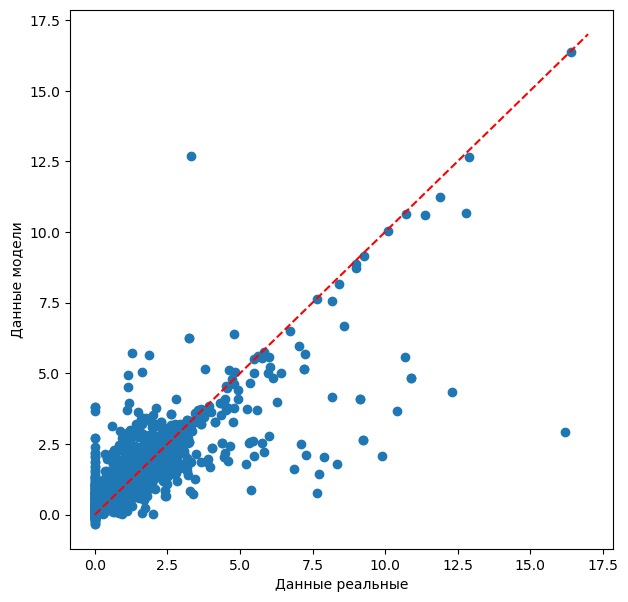

In [13]:
src.lib.model_score(model, X_test, y_test)

In [14]:
pred = model.predict(X_test)

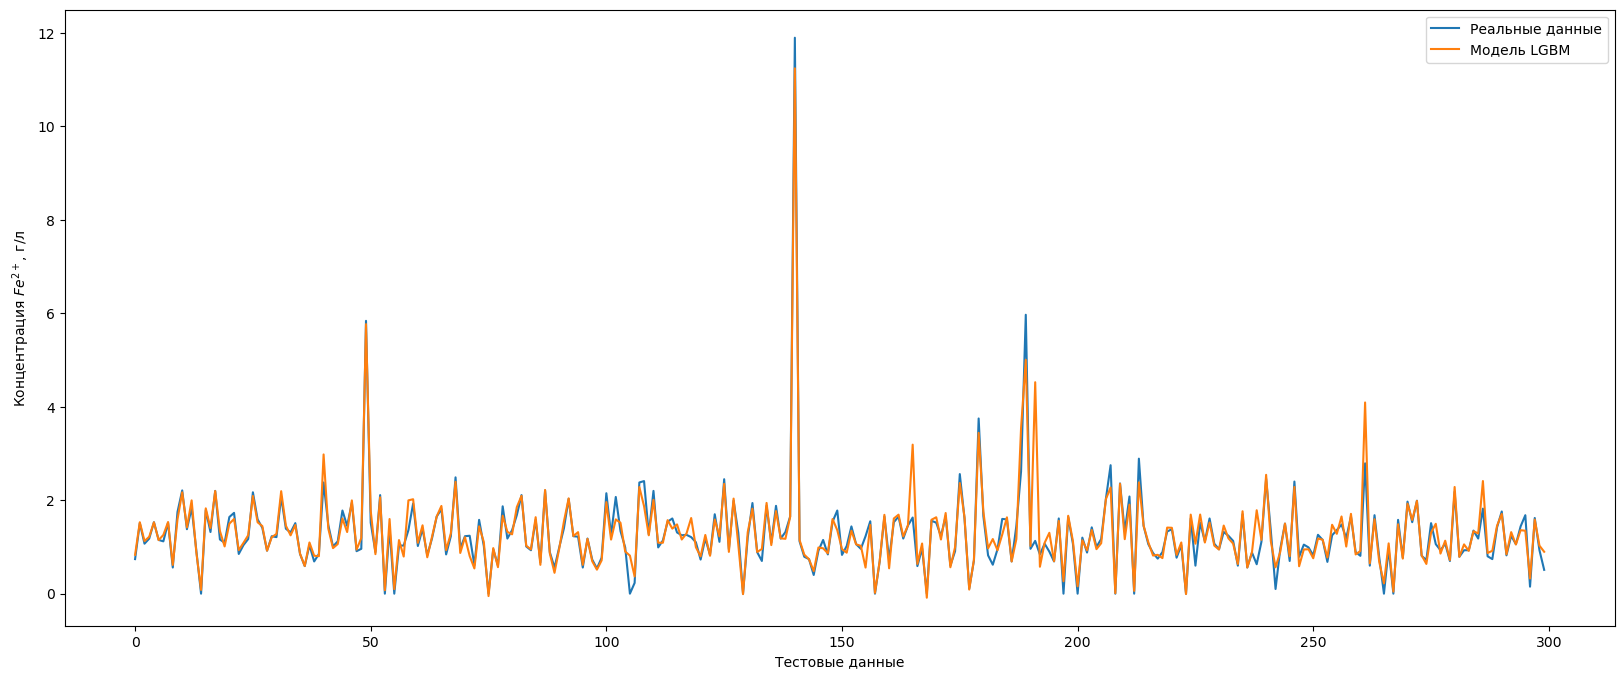

In [23]:
plt.figure(figsize=(20,8))

start = 3700
end = 4000

plt.plot(y_test.values[start:end], label='Реальные данные')
plt.plot(pred[start:end], label='Модель LGBM')

plt.ylabel("Концентрация $Fe^{2+}$, г/л")
plt.xlabel('Тестовые данные')

plt.legend()
plt.show();

## Посмотрим наиболее важные признаки

In [26]:
# model.params["objective"] = "regression"
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

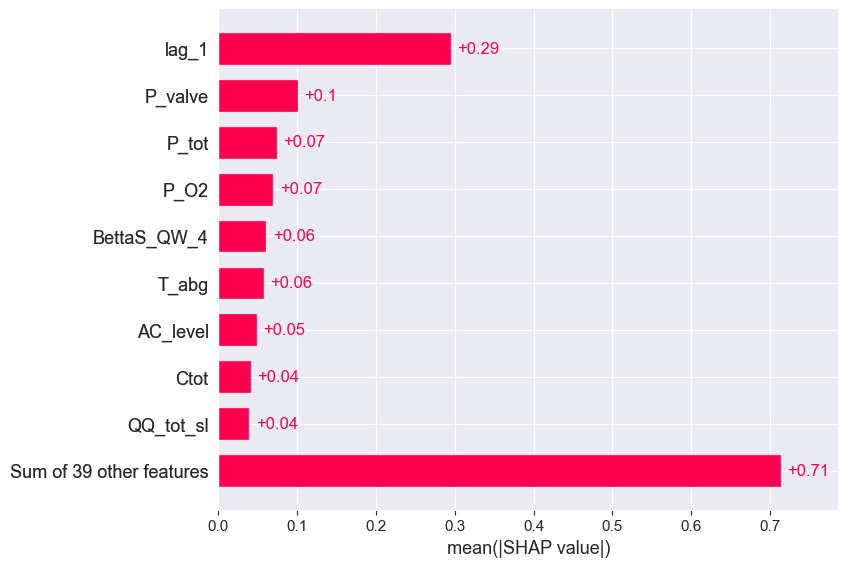

In [27]:
shap.plots.bar(shap_values)

## Сохранение модели

In [24]:
joblib.dump(model, '../models/model_lgb.pkl')

['../models/model_lgb.pkl']

Потом загрузка модели - gbm_pickle = joblib.load('lgb.pkl')